In [84]:
import torch
import SimpleITK as sitk
import pandas
import glob, os
import numpy
import tqdm
import pylidc
from torch.autograd import Variable
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [59]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [60]:
def model(t_u, w1, w2, b):
    return w2 * t_u ** 2 + w1 * t_u + b

In [61]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [62]:
w1 = torch.ones(())
w2 = torch.ones(())
b = torch.zeros(()) 
t_p = model(t_u, w1, w2, b)
t_p

tensor([1310.1901, 3180.7100, 3445.4399, 6789.5103, 3225.9900, 2440.1101,
        1183.1101,  497.0399, 2390.9600, 3708.5601, 4746.9600])

In [63]:
loss = loss_fn(t_p, t_c)
loss

tensor(11709471.)

In [64]:
delta = 0.1
loss_rate_of_change_w = \
(loss_fn(model(t_u, w1 + delta, w2 + delta, b), t_c) -
loss_fn(model(t_u, w1- delta, w2 - delta, b), t_c)) / (2.0 * delta)

In [65]:
learning_rate = 1e-4
w1 = w1 - learning_rate * loss_rate_of_change_w

In [66]:
loss_rate_of_change_b = \
(loss_fn(model(t_u, w1, w2, b + delta), t_c) -
loss_fn(model(t_u, w1, w2, b - delta), t_c)) / (2.0 * delta)
b = b - learning_rate * loss_rate_of_change_b

In [67]:
def model(t_u, w1, w2, b):
    return w2 * t_u ** 2 + w1 * t_u + b

In [68]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [69]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

In [70]:
def dmodel_dw(t_u, w1, w2, b):
    return t_u

In [71]:
def dmodel_db(t_u, w1, w2, b):
    return 1.0

In [72]:
def grad_fn(t_u, t_c, t_p, w1, w2, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw1 = dloss_dtp * dmodel_dw(t_u, w1, w2, b)
    dloss_dw2 = dloss_dtp * dmodel_dw(t_u, w1, w2, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w1, w2, b)
    return torch.stack([dloss_dw1.sum(), dloss_dw2.sum(), dloss_db.sum()])

In [73]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w1, w2, b = params
        
        t_p = model(t_u, w1, w2, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w1, w2, b)
        
        params = params - learning_rate * grad
        if epoch % 500 == 0 or epoch == 1: 
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
        
    return params

In [74]:
t_un = 0.1 * t_u
training_loop(
n_epochs = 5000,
learning_rate = 1e-1,
params = torch.tensor([1.0, 1.0, 0.0]),
t_u = t_un,
t_c = t_c)

Epoch 1, Loss 675.794373
Epoch 500, Loss nan
Epoch 1000, Loss nan
Epoch 1500, Loss nan
Epoch 2000, Loss nan
Epoch 2500, Loss nan
Epoch 3000, Loss nan
Epoch 3500, Loss nan
Epoch 4000, Loss nan
Epoch 4500, Loss nan
Epoch 5000, Loss nan


tensor([nan, nan, nan])

In [75]:
t_un = 0.1 * t_u
training_loop(
n_epochs = 5000,
learning_rate = 1e-2,
params = torch.tensor([1.0, 1.0, 0.0]),
t_u = t_un,
t_c = t_c)

Epoch 1, Loss 675.794373
Epoch 500, Loss nan
Epoch 1000, Loss nan
Epoch 1500, Loss nan
Epoch 2000, Loss nan
Epoch 2500, Loss nan
Epoch 3000, Loss nan
Epoch 3500, Loss nan
Epoch 4000, Loss nan
Epoch 4500, Loss nan
Epoch 5000, Loss nan


tensor([nan, nan, nan])

In [76]:
t_un = 0.1 * t_u
training_loop(
n_epochs = 5000,
learning_rate = 1e-3,
params = torch.tensor([1.0, 1.0, 0.0]),
t_u = t_un,
t_c = t_c)

Epoch 1, Loss 675.794373
Epoch 500, Loss 8.035689
Epoch 1000, Loss 6.636409
Epoch 1500, Loss 5.582901
Epoch 2000, Loss 4.790622
Epoch 2500, Loss 4.195589
Epoch 3000, Loss 3.749397
Epoch 3500, Loss 3.415423
Epoch 4000, Loss 3.165985
Epoch 4500, Loss 2.980155
Epoch 5000, Loss 2.842138


tensor([ 0.4414,  0.4414, -4.5622])

In [77]:
t_un = 0.1 * t_u
training_loop(
n_epochs = 5000,
learning_rate = 1e-4,
params = torch.tensor([1.0, 1.0, 0.0]),
t_u = t_un,
t_c = t_c)

Epoch 1, Loss 675.794373
Epoch 500, Loss 9.678580
Epoch 1000, Loss 9.474418
Epoch 1500, Loss 9.275946
Epoch 2000, Loss 9.082996
Epoch 2500, Loss 8.895410
Epoch 3000, Loss 8.713042
Epoch 3500, Loss 8.535755
Epoch 4000, Loss 8.363424
Epoch 4500, Loss 8.195878
Epoch 5000, Loss 8.033002


tensor([ 0.3497,  0.3497, -0.8786])

In [78]:
Housing = pd.read_csv('Housing.csv')
Housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [79]:
X = Housing[['area', 'bedrooms', 'bathrooms','stories', 'parking']]
y = Housing['price']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [81]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [82]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
area,3.272116e+02
bedrooms,1.191368e+05
bathrooms,1.141634e+06
stories,5.567184e+05
parking,3.798781e+05


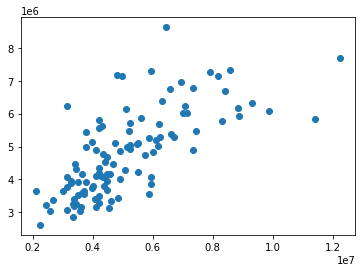

In [85]:
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions)

In [86]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

RMSE: 1366309.0766778404
